In [39]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

from model import *

from tqdm import tqdm

import pandas as pd
import numpy as np

import torch

import cv2
from PIL import Image

from model import *

# 忽略烦人的红色提示
import warnings
warnings.filterwarnings("ignore")

# 有 GPU 就用 GPU，没有就用 CPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('device', device)

device cuda:0


In [40]:
from torchvision import transforms

# # 训练集图像预处理：缩放裁剪、图像增强、转 Tensor、归一化
# train_transform = transforms.Compose([transforms.RandomResizedCrop(224),
#                                       transforms.RandomHorizontalFlip(),
#                                       transforms.ToTensor(),
#                                       transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
#                                      ])

# 测试集图像预处理-RCTN：缩放、裁剪、转 Tensor、归一化
test_transform = transforms.Compose([transforms.Resize(256),
                                     transforms.CenterCrop(224),
                                     transforms.ToTensor(),
                                     transforms.Normalize(
                                         mean=[0.485, 0.456, 0.406], 
                                         std=[0.229, 0.224, 0.225])
                                    ])

In [41]:
model = torch.load('model.pkl')
model = model.eval().to(device)

In [42]:
from torchvision.models.feature_extraction import create_feature_extractor

In [43]:
model_trunc = create_feature_extractor(model, return_nodes={'fc4': 'semantic_feature'})

In [44]:
# 读取数据
df = pd.read_csv('titanicDeath.csv', usecols=[1, 2, 4, 5])
df.replace({'性别': {'male': 1, 'female': 0}}, inplace=True)  # 设置性别为0和1
df = df.dropna()  # 删除包含NaN的行
df = np.array(df)
m, n = df.shape
# np.random.shuffle(df)
data_dev = df[0:200].T
Y_dev = data_dev[0]
X_dev = data_dev[1:n]
datat = df[200:m].T
Yt = datat[0]
Xt = datat[1:n]
# 将数据转换为PyTorch张量
Xt_tensor = torch.tensor(Xt.T, dtype=torch.float32)
Yt_tensor = torch.tensor(Yt, dtype=torch.long)

In [45]:
input_d = Xt_tensor[0].unsqueeze(0)
input_d = input_d.unsqueeze(0).to(device)

predu = model_trunc(input_d)
predu['semantic_feature'].squeeze().detach().cpu().numpy().shape

(2,)

In [46]:
encoden = []
datalist = []

for datum in tqdm(Xt_tensor):
    input_d = datum.unsqueeze(0)
    input_d = input_d.unsqueeze(0).to(device)
    predu = model_trunc(input_d)
    encoden.append(predu['semantic_feature'].squeeze().detach().cpu().numpy())
    datalist.append(datum.detach().cpu().numpy())

encoden = np.array(encoden)

100%|██████████| 846/846 [00:01<00:00, 764.63it/s]


In [47]:
encoden.shape

(846, 2)

In [48]:
np.save('encoden.npy', encoden)

In [49]:
# 

import numpy as np
import pandas as pd
import cv2

In [50]:
encodean = np.load('encoden.npy', allow_pickle=True)

encodean.shape

(846, 2)

In [51]:
classes = ['survived', 'death']
classes

['survived', 'death']

In [52]:
import seaborn as sns

marker_list = ['o', 'x']

In [53]:
class_list = np.array(classes)
class_list

array(['survived', 'death'], dtype='<U8')

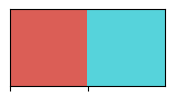

In [54]:
palette = sns.hls_palette(len(classes))
sns.palplot(palette)

In [55]:
# 降维

from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, n_iter=3000)
X_tsne_2d = tsne.fit_transform(encodean)

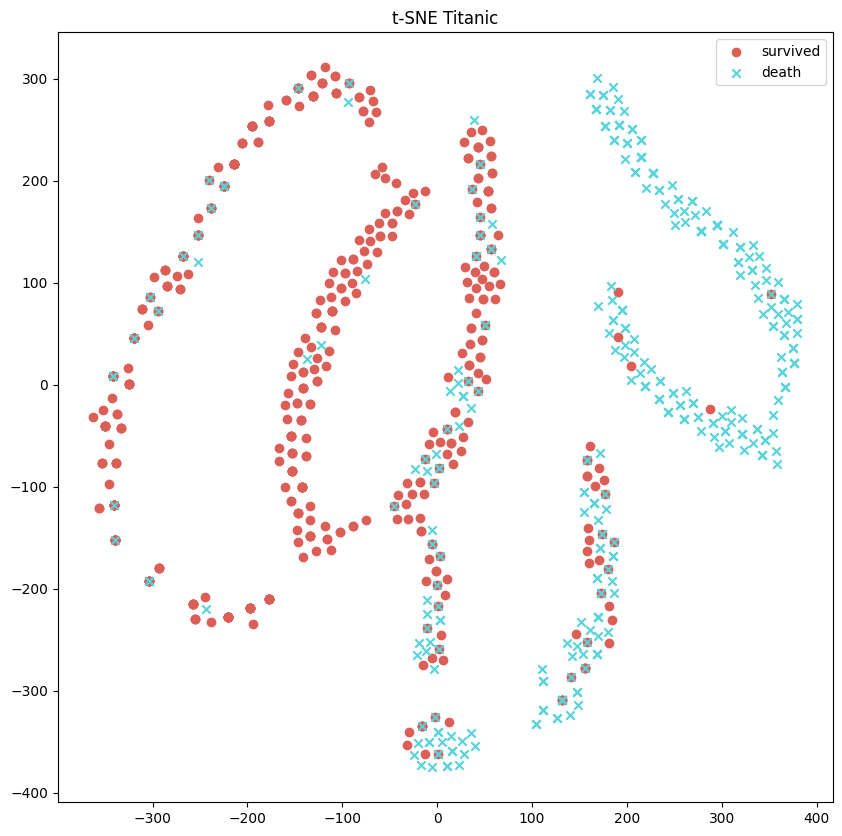

In [56]:
plt.figure(figsize=(10, 10))

for idx, cl in enumerate(classes):
    plt.scatter(x=X_tsne_2d[Yt == idx, 0], 
                y=X_tsne_2d[Yt == idx, 1], 
                c=palette[idx], 
                marker=marker_list[idx], 
                label=cl)
plt.legend()
plt.title('t-SNE Titanic')
plt.show()

In [57]:
import plotly.express as px